In [1]:
import xarray as xr
import geopandas as gpd
import rioxarray
import pandas as pd
from datetime import date
from matplotlib import pyplot as plt
import numpy as np
import pyproj
import pickle
import matplotlib.dates as mdates

In [2]:
# Lazily load all HS netcdf 
ds = xr.open_mfdataset('snd_UERRA_MESCAN_SURFEX_1980_2014_alps/snd_UERRA_MESCAN_SURFEX_day_*.nc')

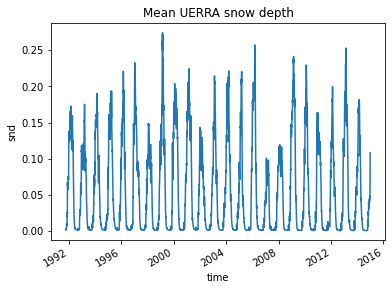

In [3]:
# Select period of interest 
datesSel = ds['time'].sel(time=slice('1991-10-01', '2021-7-01')) # exceeds 1984-2014
# reduce UERRA dataset to these dates
dsSel = ds.sel(time=datesSel)
# plot mean snow depth
dsSel.snd.mean(dim=('x','y')).plot()
plt.title('Mean UERRA snow depth');

In [4]:
# Make X array with predictors
X = dsSel['snd'].values.reshape(datesSel.size,-1)
# remove nodata [TODO: APPLY MODIS AOI MASK]
ix = np.all(np.isnan(X),axis=0)
# This is the array of training data (snow depth of every cell)
X = X[:,~ix]

In [5]:
mod = pickle.load( open( "mod2AlpsScf01July.pickle", "rb" ) )

In [6]:
xmod = mod.predict(X)

In [11]:
def plotYear(year,xmod):
    fig = plt.figure(figsize=(12, 5), dpi=100)
    (ax1, ax2) = fig.subplots(ncols=2, sharey=True)

    ax1.plot(datesSel,xmod, label='Predicted from UERRA')
    ax1.set_ylabel('Snow cover fraction')
    ax1.set_xlabel('Time')

    ax2.plot(datesSel,xmod, label='Predicted from UERRA')
    ax2.set_xlabel('Time')

    ax1.set_title('{}-{}'.format(year,year+1))
    ax2.set_title('{}-{}'.format(year+1,year+2))
    ax1.set_xlim([date(year,10,1), date(year+1,7,10)])
    ax2.set_xlim([date(year+1,10,1), date(year+2,7,10)])
    ax1.legend()
    ax2.legend()
    ax1.set_ylim([0,1])
    
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))


In [12]:
# convert dates to millis (POSIX) to match 'system:time_start' in earth engine
millis = pd.Series(datesSel, name='system:time_start')
millis = millis.apply(lambda x: x.timestamp()*1000 )
# convert dates at 6:00 to date only
#dates = pd.Series(datesSel, name='dates').dt.date

In [13]:
# concat scf
scf = pd.concat([millis, pd.Series(xmod, name='scf')], axis = 1)
scf.set_index('system:time_start',inplace=True)
scf.to_csv('export/predicteedScf.csv')

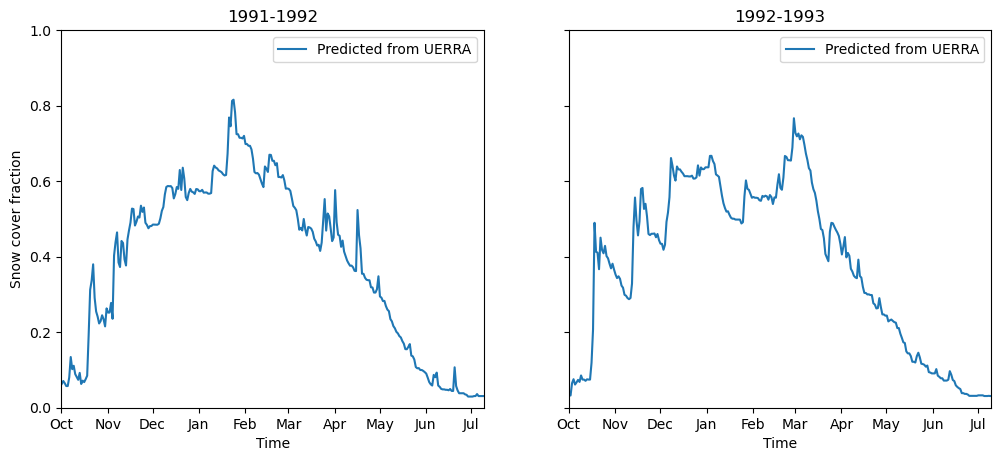

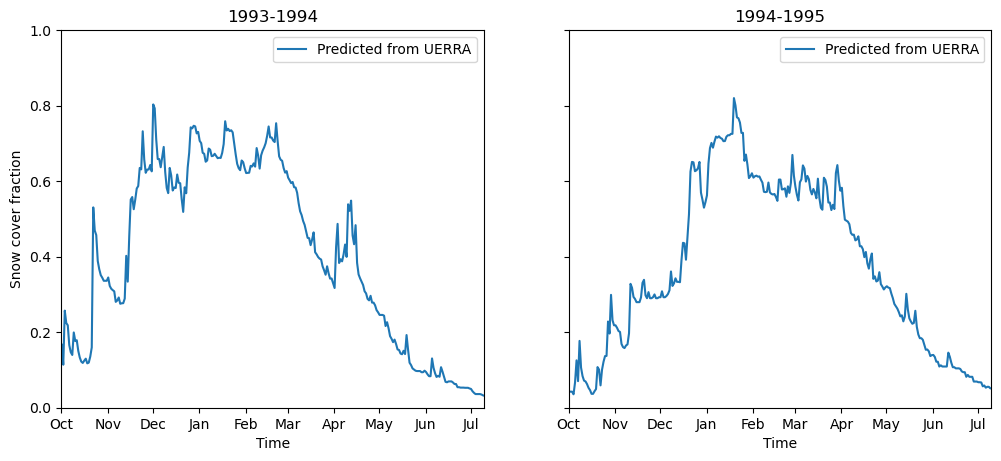

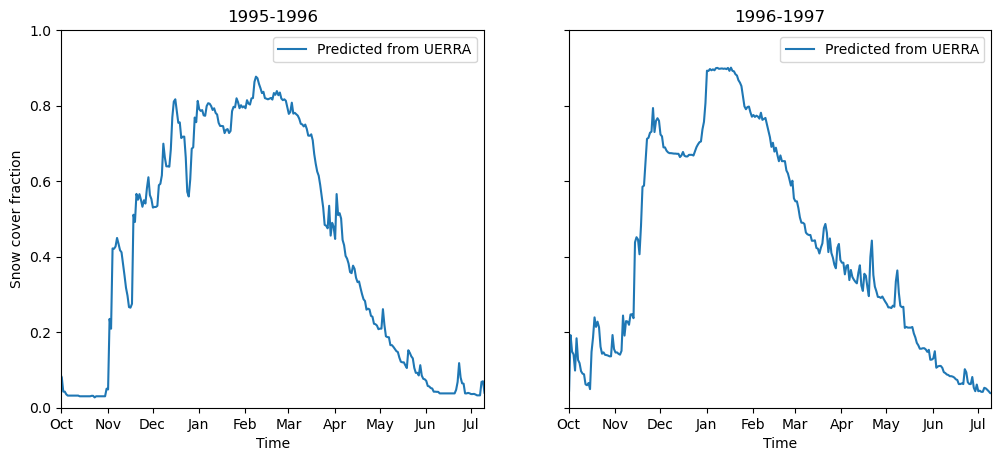

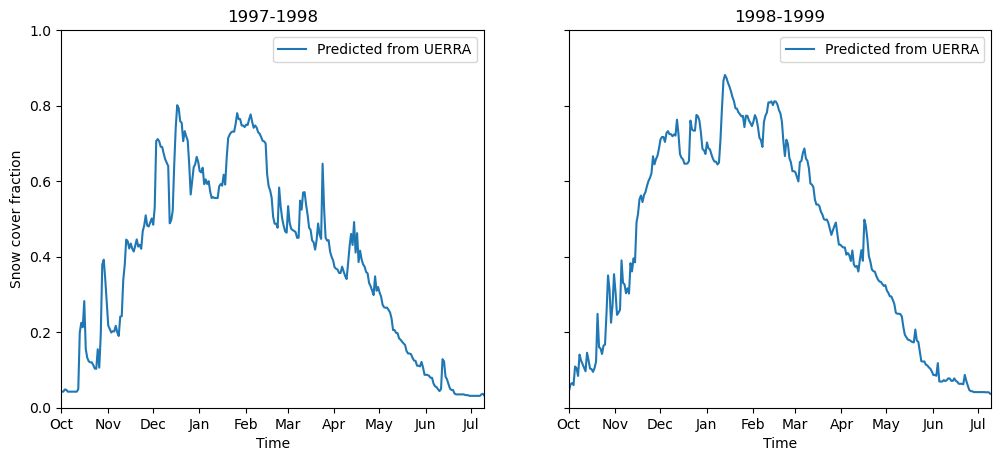

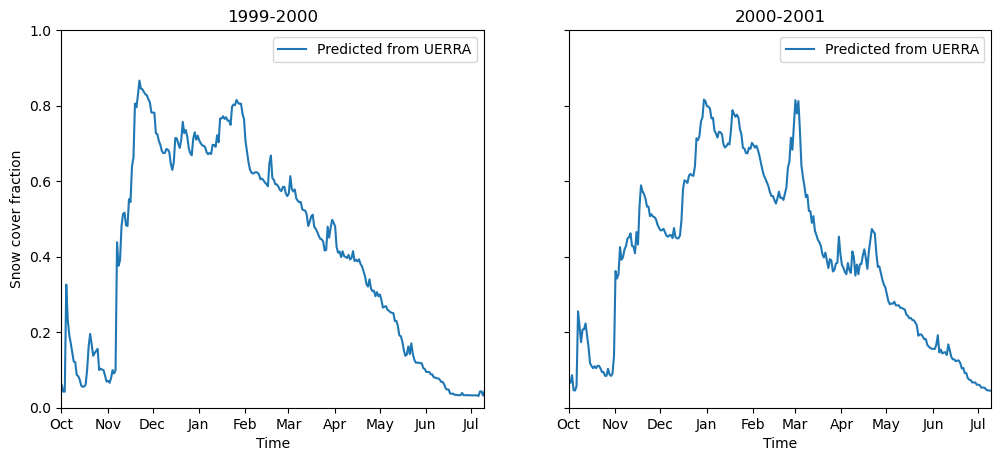

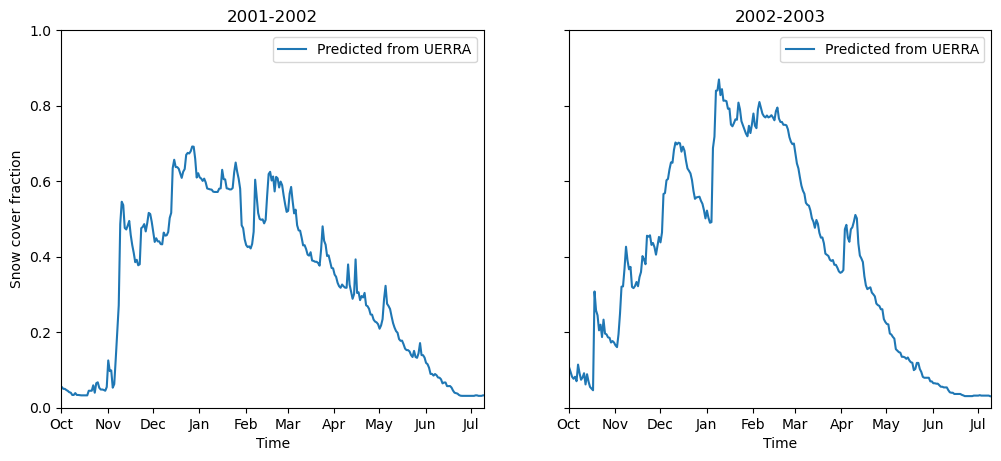

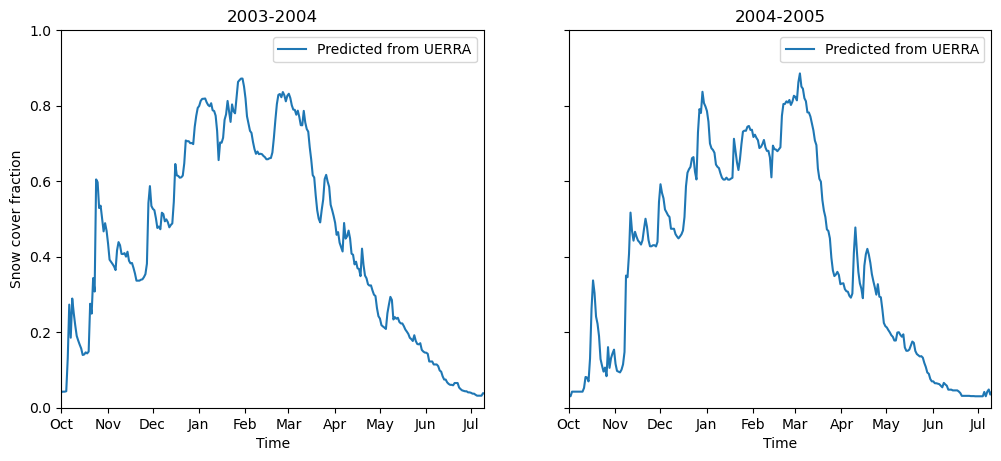

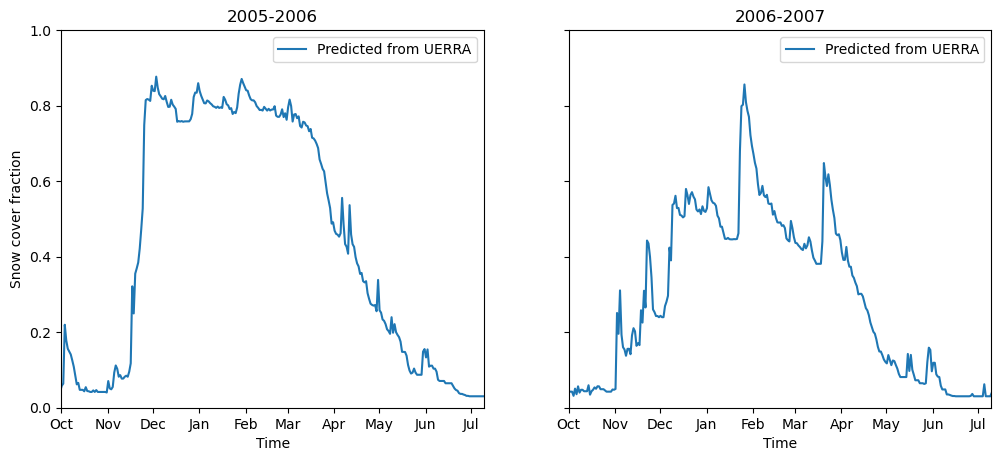

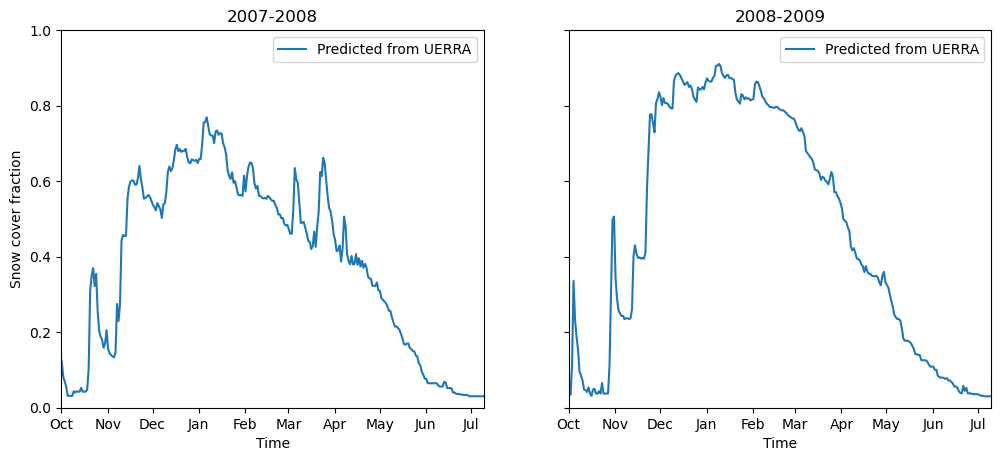

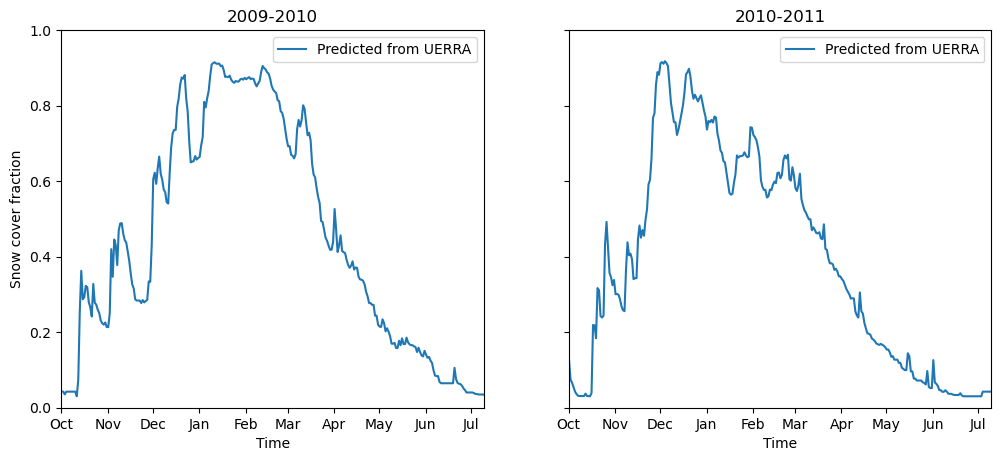

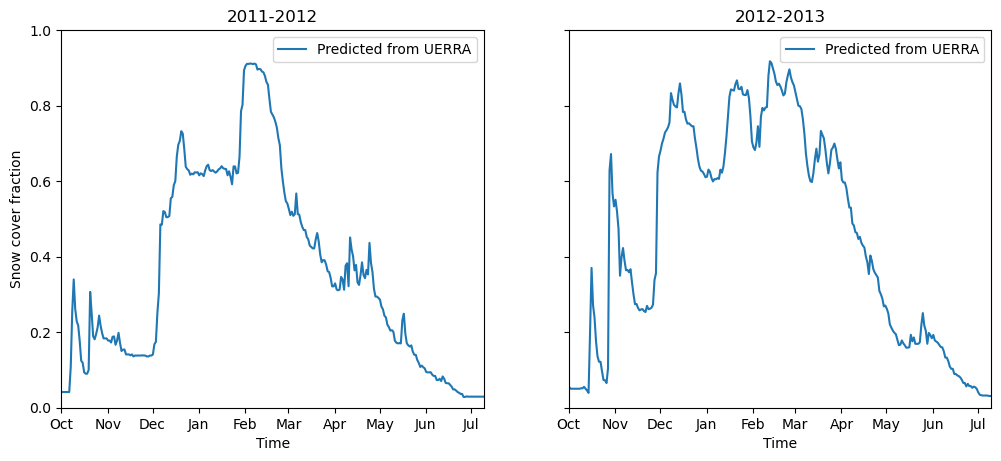

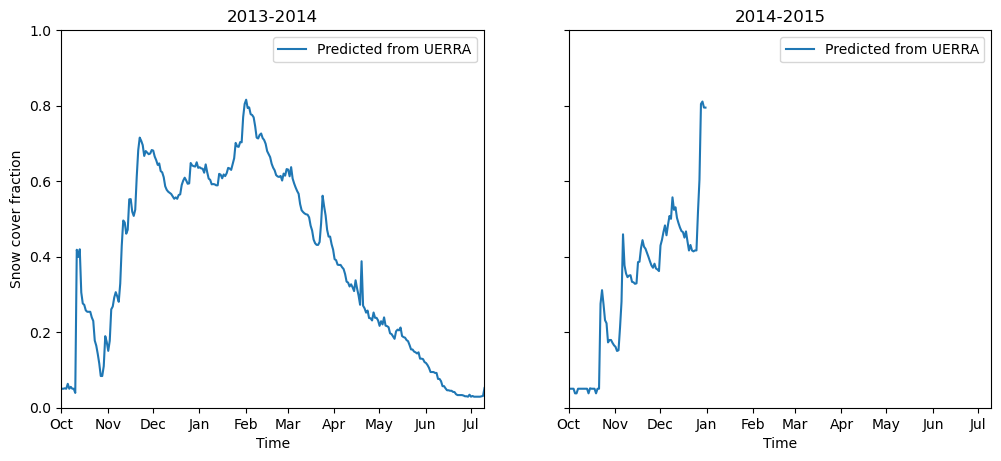

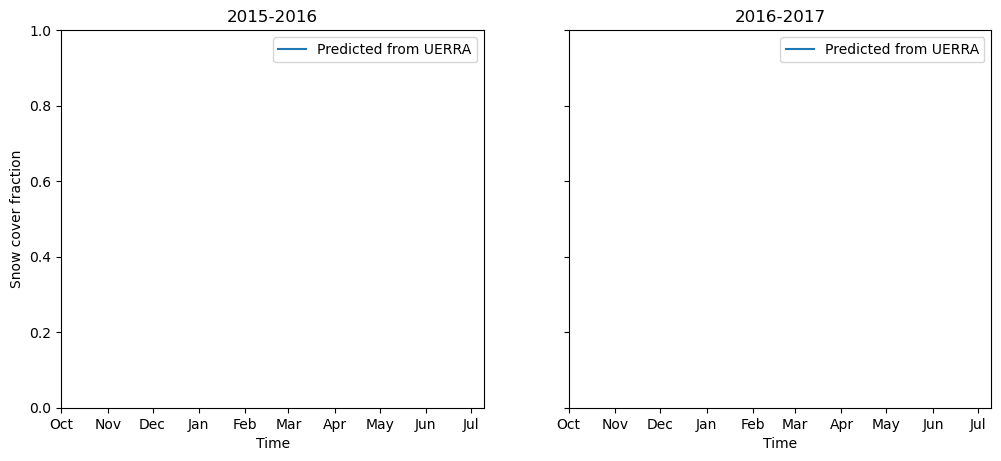

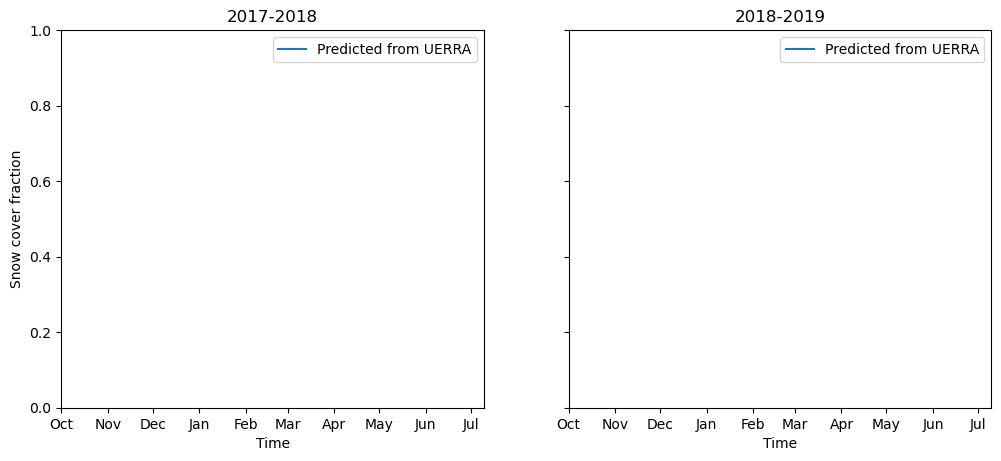

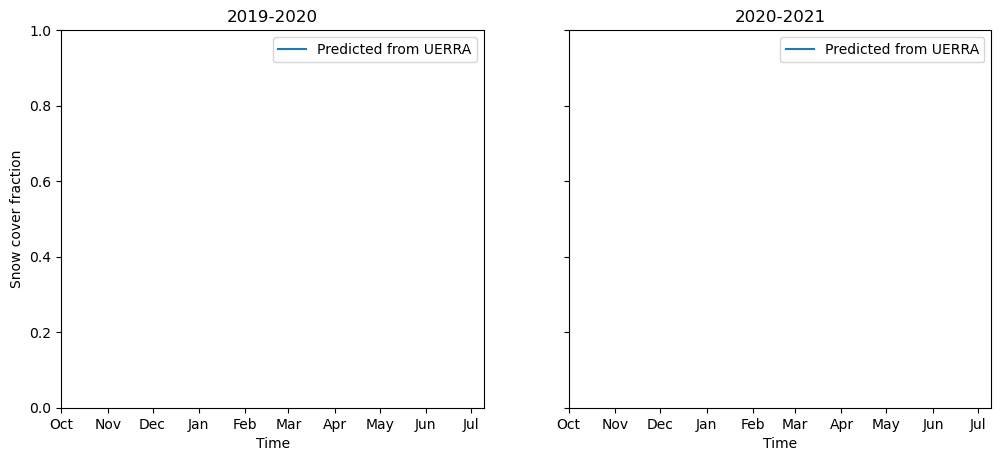

In [14]:
for year in range(1991,2021,2):
    plotYear(year,xmod)